<a href="https://colab.research.google.com/github/stswee/InclusiveDataHackathon/blob/main/InclusiveHackathonFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Preliminaries
# May have to unmount and mount Google Drive
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
# !pip install catboost
# from catboost import CatBoostClassifier, Pool, metrics, cv
from datetime import datetime, timedelta
from statsmodels.graphics.mosaicplot import mosaic

In [ ]:
# Data Source: https://www.kaggle.com/datasets/kartik2112/fraud-detection
! kaggle datasets download kartik2112/fraud-detection
! unzip fraud-detection.zip

 99% 199M/202M [00:01<00:00, 155MB/s]
100% 202M/202M [00:01<00:00, 135MB/s]
Archive:  fraud-detection.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          


In [ ]:
# Load in data (~10s)
df = pd.read_csv("fraudTrain.csv")
# 1296675 rows, 23 columns

In [ ]:
df['Repeated'] = False

In [ ]:
# Add columns (to be used for data exploration and testing)
# Add 24 hour
def get_hour_from_unix_time(unix_time):
    timestamp = datetime.utcfromtimestamp(unix_time)
    hour = timestamp.strftime('%H')
    return int(hour)
hour = pd.Series(df['unix_time'])
hour = hour.apply(get_hour_from_unix_time)
df['hour'] = hour

In [ ]:
# Add repeated transaction within past week
def check_integer_repeated_within_week(dataframe, target_integer, time_threshold, amt_threshold):
    dataframe['Datetime'] = pd.to_datetime(dataframe['unix_time'], unit='s')
    #dataframe.sort_values(by='Datetime', inplace=True)
    #dataframe.reset_index(drop=True, inplace=True)

    threshold_time = timedelta(days = time_threshold)
    target_integer_repeated_within_week = False
    for i in range(1, len(dataframe)):
        if dataframe.loc[i, 'cc_num'] == target_integer and dataframe.loc[i-1, 'cc_num'] == target_integer:
            time_diff = dataframe.loc[i, 'Datetime'] - dataframe.loc[i-1, 'Datetime']
            amt1 = dataframe.loc[i, 'amt']
            amt2 = dataframe.loc[i - 1, 'amt']
            if (time_diff <= threshold_time) and (amt1 > amt_threshold) and (amt2 > amt_threshold):
                target_integer_repeated_within_week = True
                break
    return target_integer_repeated_within_week

# Set time threshold (number of days)
time_threshold = 7

# Set amount threshold
amt_threshold = 250

# Determine repeats (~3 hours and 30 minutes)
cc_num_list = {'cc_num': df['cc_num'].unique(), 'Repeated' : [False] * len(df['cc_num'].unique())}
cc_num_list = pd.DataFrame(cc_num_list)
for i in range(len(df['cc_num'].unique())):
  print(i)
  cc_num_list['Repeated'][i] = check_integer_repeated_within_week(df, cc_num_list['cc_num'][i], time_threshold, amt_threshold);
cc_num_list.to_csv("cc_num_repeat.csv", index=False)
# df.update(cc_num_list[['Repeated']])

In [ ]:
# Load repeated cc numbers
cc_num_repeat = pd.read_csv("cc_num_repeat.csv")
cc_num_repeated = cc_num_repeat.loc[cc_num_repeat['Repeated'] == True]
cc_num_repeated = cc_num_repeated['cc_num'].unique()

# Designate cc numbers as repeated
for i in range(len(df['cc_num'])):
  print(i)
  if (df['cc_num'][i] in cc_num_repeated):
    df['Repeated'][i] = True

In [ ]:
# Save updated training data
df.to_csv("fraudTrainUpdated.csv", index = False)

In [ ]:
# Load in updated training data
df = pd.read_csv("fraudTrainUpdated.csv")

<ipython-input-4-104fdbc4d166>:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("fraudTrainUpdated.csv")


In [ ]:
# Get non-fraud data only (for exploratory purposes)
df_nofraud = df[df['is_fraud'] == 0]
# 1289169 rows, 25 columns

# Get fraud data only (for exploratory purposes)
df_fraud = df[df['is_fraud'] == 1]
# 7506 rows, 25 columns

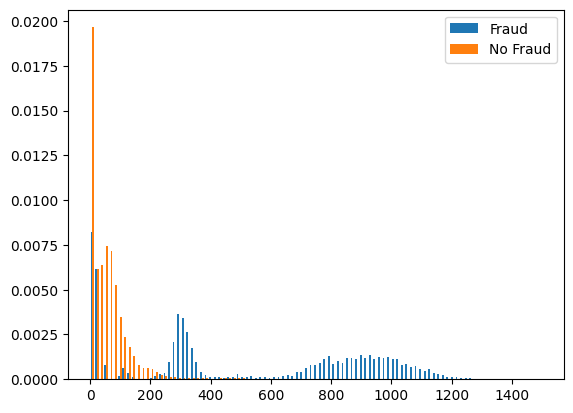

In [ ]:
# Explore amount vs. fraud
# 1500 chose as cutoff for histogram since majority of transactions are below that value
bins = np.linspace(0, 1500, 100)
plt.hist([df_fraud['amt'], df_nofraud['amt']], bins, label = ['Fraud', 'No Fraud'], density = True);
plt.legend(loc='upper right');

# From histogram, appears that threshold of $250 seems reasonable in distinguishing fraud and no fraud

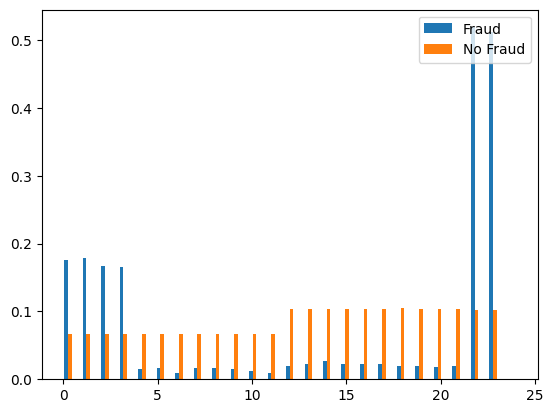

In [ ]:
# Explore time of day vs fraud
bins = np.linspace(0, 24)
plt.hist([df_fraud['hour'], df_nofraud['hour']], bins, label = ['Fraud', 'No Fraud'], density = True);
plt.legend(loc='upper right');

# Appears that most fraudulent transactions occur between 22:00 and 3:00

In [ ]:
# Explore repeated numbers vs. fraud
contingency_table = pd.crosstab(df['Repeated'], df['is_fraud'])
print(contingency_table)

value_00 = contingency_table.iloc[0,0] # Correct Negative
value_01 = contingency_table.iloc[0,1] # False Negative
value_10 = contingency_table.iloc[1,0] # Correct Positive
value_11 = contingency_table.iloc[1,1] # False Positive

accuracy = (value_00 + value_01) / (value_00 + value_01 + value_10 + value_11)
print(accuracy * 100)

# From the contingency table, we get 96% accuracy
# However, we note that of the fraudulent cases, only 423/(7083+423) = 6% of cases were considered repeated

is_fraud     0.0   1.0
Repeated              
False     740966  4309
True       32287   276
95.81365271431841


In [ ]:
# Set risk column (~ 15min)
df['Risk'] = 0
for i in range(len(df['cc_num'])):
  print(i)
  array = [df['amt'][i] > 250, df['hour'][i] <= 3, df['hour'][i] >= 22, df['Repeated'][i] == True]
  count = sum(1 for value in array if value)
  df['Risk'][i] = count

In [ ]:
# Save updated training data
df.to_csv("fraudTrainUpdated.csv", index = False)

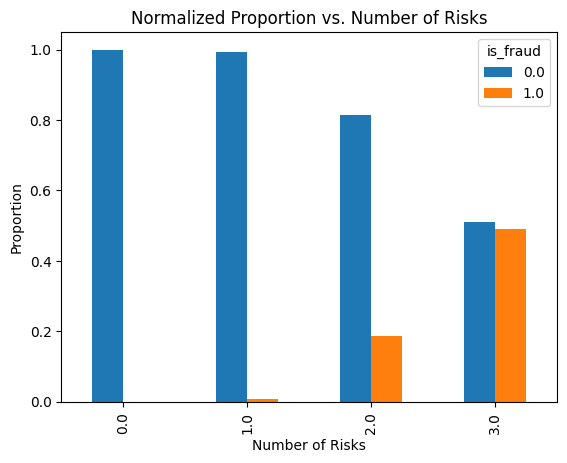

In [ ]:
# Plot Fraud vs. Risk
grouped_data = df.groupby(['Risk', 'is_fraud']).size().unstack(fill_value = 0)
grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)
grouped_data.plot(kind = 'bar', stacked = False)
plt.xlabel("Number of Risks")
plt.ylabel("Proportion")
plt.title("Normalized Proportion vs. Number of Risks")
plt.show()

In [ ]:
grouped_data

is_fraud,0,1
Risk,,
0,0.999694,0.000306
1,0.993261,0.006739
2,0.813407,0.186593
3,0.525084,0.474916


In [ ]:
# Load in updated training data
df = pd.read_csv("fraudTrainUpdated.csv")